# Model with segmentation and augmentation

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split

from  PIL import Image

from elle_ebene.utils.simple_preprocessing import get_images, to_numpy_rgb, squared_imgs, create_dataset
from elle_ebene.hair_segmentation.hair_seg import HairSegmenter
from elle_ebene.utils.data_aug_c import Hairgenerator


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras import regularizers

## Dataset

In [2]:
type3_imgs = get_images("Type 3",resizing_dim=224)
type4_imgs = get_images("Type 4",resizing_dim=224)

In [3]:
type3_imgs_rgb = to_numpy_rgb(type3_imgs)
type4_imgs_rgb = to_numpy_rgb(type4_imgs)

In [4]:
type3_imgs_squared = squared_imgs(type3_imgs_rgb)
type4_imgs_squared = squared_imgs(type4_imgs_rgb)

In [5]:
segmenter = HairSegmenter()
segmenter.model_init()

In [6]:
hairs_type3 = segmenter.get_hairs(type3_imgs_squared)
hairs_type4 = segmenter.get_hairs(type4_imgs_squared)

In [7]:
type3_labels = np.full((len(hairs_type3),),3)
type4_labels = np.full((len(hairs_type4),),4)

In [59]:
X, y = create_dataset([hairs_type3, hairs_type4], [type3_labels, type4_labels])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Normalisation et encoding

In [60]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [61]:
y_train = to_categorical(y_train,5)[:,-2:]
y_val = to_categorical(y_val,5)[:,-2:]
y_test = to_categorical(y_test,5)[:,-2:]

## Data augmentation

In [62]:
augmenter = Hairgenerator()

In [66]:
augmenter.datagen(X_train, y_train, batch_size=16, rotation_range=20, width_shift_range=0.1,
                  height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest',
                  brightness_range=None)

## Model

In [67]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [72]:
def initialize_model():
   
    model  = models.Sequential()
    
    ### First convolution & max-pooling
    model.add(layers.Conv2D(16, kernel_size=(4, 4), activation='relu', input_shape=(224, 224, 3), padding = "same"))
    #model.add(layers.Dropout(rate=0.2))
    
    ### Second convolution
    model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(layers.MaxPool2D(pool_size = (4,4)))    
    #model.add(layers.Dropout(rate=0.2))
    
    ### Third convolution
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same"))  
    #model.add(layers.Dropout(rate=0.2))
    
    ### Fourth convolution
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(layers.MaxPool2D(pool_size = (4,4)))    
    #model.add(layers.Dropout(rate=0.2))
    
    ### Flattening
    model.add(layers.Flatten())
    
    ### One fully connected
    model.add(layers.Dense(32, activation='relu')) 
    #model.add(layers.Dropout(rate=0.2))

    ### Last layer
    model.add(layers.Dense(2, activation='sigmoid')) 

    model.compile(loss='binary_crossentropy',
            optimizer=optimizers.Adam(learning_rate = 0.001),
            metrics=['accuracy'])
    
    return model

In [73]:
model = initialize_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 224, 224, 16)      784       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6272)            

In [74]:
# learning rate schedule
def step_decay(epoch, lr):
    decay = 0.5
    lr *= (1. / (1. + decay * epoch))
    return lr

In [75]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor = "val_loss")
lrate = LearningRateScheduler(step_decay)
callbacks_list = [es]
history = model.fit(augmenter.hair_flow, validation_data = (X_val, y_val),
          epochs=200, batch_size=16, verbose=1, callbacks = callbacks_list)

Epoch 1/200
17/17 [==============================] - 9s 528ms/step - loss: 0.7355 - accuracy: 0.4427 - val_loss: 0.6945 - val_accuracy: 0.4848
Epoch 2/200
17/17 [==============================] - 10s 575ms/step - loss: 0.6926 - accuracy: 0.4847 - val_loss: 0.6913 - val_accuracy: 0.5152
Epoch 3/200
17/17 [==============================] - 11s 607ms/step - loss: 0.6898 - accuracy: 0.5305 - val_loss: 0.6865 - val_accuracy: 0.5152
Epoch 4/200
17/17 [==============================] - 10s 570ms/step - loss: 0.6867 - accuracy: 0.5496 - val_loss: 0.6779 - val_accuracy: 0.6970
Epoch 5/200
17/17 [==============================] - 10s 584ms/step - loss: 0.6707 - accuracy: 0.6145 - val_loss: 0.6646 - val_accuracy: 0.5606
Epoch 6/200
17/17 [==============================] - 9s 536ms/step - loss: 0.6426 - accuracy: 0.6145 - val_loss: 0.6415 - val_accuracy: 0.5758
Epoch 7/200
17/17 [==============================] - 9s 531ms/step - loss: 0.6144 - accuracy: 0.6756 - val_loss: 0.6677 - val_accuracy: 0.

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

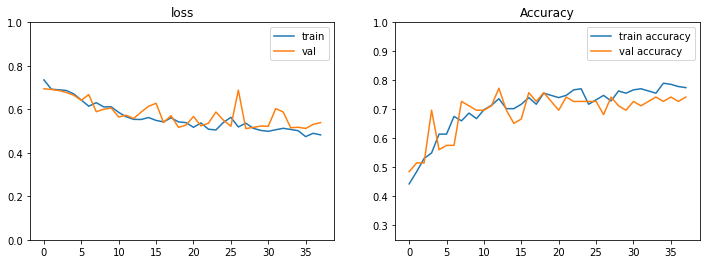

In [76]:
plot_history(history)

In [77]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 140ms/step - loss: 0.5140 - accuracy: 0.7561


[0.5140107274055481, 0.7560975551605225]

In [78]:
model.save_weights("/home/aymeric/code/Aymeric-B/elle_ebene/model_weights/seg_aug/weights")